# Comprehensive Fine-Tuning

Building on the strong performance of the fully fine-tuned model, this sub-notebook explores whether further performance gains can be achieved by tuning critical training hyperparameters: **initial learning rate**, **learning rate scheduler**, **batch size**, **optimizer**, and **dropout rate**. These components directly impact convergence behavior, regularization strength, and model generalization.

Because several of these parameters interact with one another, many are tested in coordinated sweeps while holding others constant. The structure of this notebook is as follows:

### Grid Search: Learning Rate × Scheduler × Batch Size

A 3-dimensional grid search is performed to test the joint impact of:
- **Learning Rate (LR):** Controls the magnitude of each weight update. A lower rate tends to favor stable convergence, while a higher one may speed up training but increase the risk of overshooting.
- **Scheduler:** Adjusts the learning rate over time. Linear, cosine, and polynomial decays are tested to see which best balances stability and convergence under short training cycles.
- **Batch Size:** Influences the granularity of gradient updates. Smaller batches introduce more noise, which can help generalization; larger batches produce smoother updates but may overfit or converge poorly on small datasets.

The grid search spans:
- 3 learning rates  
- 3 scheduler types  
- 3 batch sizes  

This results in **27 unique training runs**, each conducted over **2 epochs**, for a total of 54 effective epochs.

### Optimizer Comparison

With the best configuration from the grid search fixed, several optimizers are benchmarked to evaluate their impact on training dynamics and final model performance:
- **Adam**
- **AdamW**
- **RMSprop**
- **Nadam**
- **SGD**

Each optimizer is paired with the same cosine decay schedule and bin-weighted loss, allowing for direct performance comparison. The goal is to determine which update rule best fits this dataset and training regime.

### Dropout Regularization

Next, the effect of varying dropout rates in the classification head is assessed:
- Dropout rates of `[0.0, 0.1, 0.2, 0.3, 0.4]` are tested.
- All other settings are held fixed to isolate the role of dropout in preventing overfitting.

This step evaluates whether additional regularization can yield improvements, particularly under short training schedules and a relatively small dataset.

### Overfitting Diagnostics

Finally, training and validation metrics are plotted to assess whether overfitting is occurring. The best configuration is re-run with tracking enabled across epochs to visually compare training and validation loss/accuracy curves.

This helps confirm whether the selected model setup generalizes well or requires additional regularization or early stopping mechanisms.

> Note: This is a relatively computationally expensive notebook due to the depth of the grid search and hyperparameter testing

# Imports

In [1]:
!pip install transformers scikit-learn pandas numpy tqdm tensorflow
!pip install -q datasets

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, create_optimizer, DefaultDataCollator, AutoTokenizer
from datasets import load_dataset # Hugging Face
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    TFAutoModelForSequenceClassification,
    AutoTokenizer,
    create_optimizer
)
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter, defaultdict


import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

# Re-Run Model

To keep this notebook self-contained and reproducible, we re-load the best-performing model checkpoint from Part 5. This avoids cross-referencing other notebooks or relying on intermediary files. Minor differences in weights due to training randomness or versioning won't affect the grid search conclusions, the focus is on relative model performance across controlled hyperparameter variations.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 44s 184ms/step - loss: 0.5063 - accuracy: 0.6788 - val_loss: 0.0118 - val_accuracy: 0.9336
Epoch 2/3
114/114 [==============================] - 18s 162ms/step - loss: 0.0998 - accuracy: 0.9707 - val_loss: 0.0045 - val_accuracy: 0.9381
Epoch 3/3
15/15 [==============================] - 2s 44ms/step

Test Accuracy: 0.9471

Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.80      0.87        30
     Neutral       0.99      0.97      0.98       142
    Positive       0.85      0.96      0.91        55

    accuracy                           0.95       227
   macro avg       0.93      0.91      0.92       227
weighted avg       0.95      0.95      0.95       227



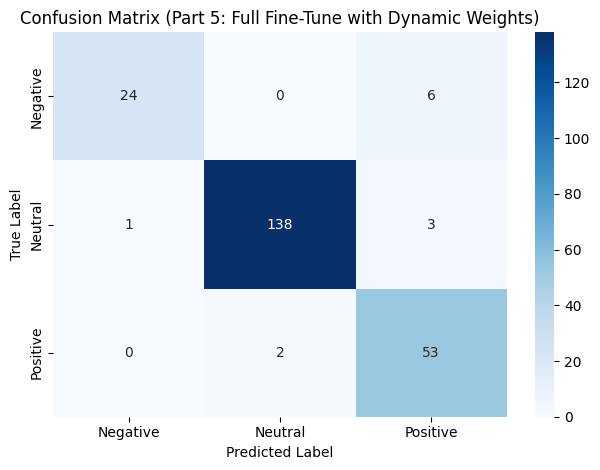

In [2]:
# Load model checkpoint
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

def compute_length_and_bin(example):
    length = len(tokenizer.tokenize(example["sentence"]))
    example["token_length"] = length
    return example

dataset = dataset.map(compute_length_and_bin)

lengths = dataset["train"]["token_length"]
q1, q2 = np.percentile(lengths, [33, 66])

def assign_bin(example):
    length = example["token_length"]
    if length <= q1:
        example["bin_index"] = 0
    elif length <= q2:
        example["bin_index"] = 1
    else:
        example["bin_index"] = 2
    return example

dataset = dataset.map(assign_bin)

# Tokenize and include bin_index
def tokenize_with_bin(example):
    tokens = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=256)
    tokens["label"] = example["label"]
    tokens["bin_index"] = example["bin_index"]
    return tokens

tokenized_datasets = dataset.map(tokenize_with_bin, batched=True)

# Train/val/test split
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

# Compute weight matrix
bin_class_counts = defaultdict(Counter)
for row in train_val_split["train"]:
    bin_class_counts[row["bin_index"]][row["label"]] += 1

weight_matrix = np.zeros((3, 3))
for bin_id, class_counts in bin_class_counts.items():
    total = sum(class_counts.values())
    for cls, count in class_counts.items():
        weight_matrix[bin_id][cls] = total / (len(class_counts) * count)

weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

# Convert HuggingFace dataset to TF dataset
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_val = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test = to_tf_dataset(val_test_split["test"], shuffle=False)

# Define wrapper model with dynamic class weighting
class CustomDistilBERT(tf.keras.Model):
    def __init__(self, base_model, weight_tensor):
        super().__init__()
        self.model = base_model
        self.weight_tensor = weight_tensor

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

    def train_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True).logits
            weights = tf.gather_nd(
                self.weight_tensor,
                tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
            )
            loss = self.loss_fn(y_true, logits)
            weighted_loss = tf.reduce_mean(loss * weights)
        grads = tape.gradient(weighted_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def test_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        logits = self.model(x, training=False).logits
        weights = tf.gather_nd(
            self.weight_tensor,
            tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
        )
        loss = self.loss_fn(y_true, logits)
        weighted_loss = tf.reduce_mean(loss * weights)
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def call(self, inputs):
        inputs = inputs.copy()
        inputs.pop("bin_index", None)
        return self.model(inputs)

base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
base_model.trainable = True  

# Wrap with dynamic-weight model
model = CustomDistilBERT(base_model, weight_tensor)


optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)  
model.compile(optimizer=optimizer)

history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=3  
)

logits = model.predict(tf_test).logits
y_pred = np.argmax(logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test], axis=0)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Part 5: Full Fine-Tune with Dynamic Weights)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Full 3D Grid Search: Learning Rate × Scheduler × Batch Size

To fine-tune our model effectively, we perform a structured 3-way grid search over three tightly coupled hyperparameters:

1. **Learning Rate**
   The learning rate controls the size of each gradient descent step during training. Too high, and the model may overshoot minima; too low, and training becomes slow or gets stuck in local minima.

   **Values tested:** `[7e-5, 5e-5, 3e-5]`
   These are standard fine-tuning ranges for DistilBERT. A higher-end value (7e-5) is included to accommodate the relatively small size of our dataset, where larger steps might be tolerable and even beneficial for convergence.

2. **Learning Rate Scheduler**
   A scheduler adjusts the learning rate over time — typically decreasing it to allow the model to "settle" into minima more smoothly.
   
   **Schedulers tested:**
   * `"cosine"`: gradually reduces the learning rate in a smooth curve, often effective when fine-tuning with few epochs
   * `"linear"`: decreases learning rate at a constant rate, a common baseline
   * `"polynomial"`: decays learning rate more aggressively early on, which may help avoid overfitting on small datasets
     
     These choices let us evaluate how aggressive or smooth learning rate decay affects performance, especially in tandem with batch size.

3. **Batch Size**
   Batch size determines how many samples are processed together before updating weights.
   
   **Batch sizes tested:** `[8, 16, 32]`
   Our dataset has moderate length variation across samples, so we balance memory use and convergence stability.

   * Small batches (8) introduce gradient noise, which can help generalization
   * Large batches (32) offer better gradient estimates and faster training, provided overfitting is controlled (via schedulers or dropout)

### Why These Three Together?

These three parameters interact closely during training:

* A larger batch size enables a larger learning rate due to more stable gradient estimates
* A more aggressive scheduler (e.g., polynomial) may be needed when training with a larger batch size or higher learning rate to prevent overfitting
* A smaller learning rate may benefit from cosine decay to allow gentle convergence on smaller batches

By exploring them in a **3-dimensional grid**, we gain insight into not only their individual effects but also their combined impact on performance — something that cannot be captured by tuning them independently.


In [12]:
# Re-apply token length and binning to static_train and static_val
static_train = static_train.map(compute_length_and_bin)
static_train = static_train.map(assign_bin)

static_val = static_val.map(compute_length_and_bin)
static_val = static_val.map(assign_bin)


# Updated to_tf_dataset to include bin_index
def to_tf_dataset(split, shuffle=False, batch_size=16):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=None
    )

# Hyperparameter grid
learning_rates = [7e-5, 5e-5, 3e-5]
schedulers = ["polynomial", "cosine", "linear"]
batch_sizes = [8, 16, 32]
search_space = list(product(learning_rates, schedulers, batch_sizes))

# Pure function to train and evaluate
def train_and_evaluate_model(lr, scheduler_name, batch_size):
    tf_train_dataset = to_tf_dataset(static_train, shuffle=True, batch_size=batch_size)
    tf_val_dataset = to_tf_dataset(static_val, shuffle=False, batch_size=batch_size)

    steps_per_epoch = len(tf_train_dataset)
    total_steps = steps_per_epoch * 2
    warmup_steps = int(0.1 * total_steps)

    base_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
    base_model.trainable = True
    model = CustomDistilBERT(base_model, weight_tensor)

    optimizer, _ = create_optimizer(
        init_lr=lr,
        num_train_steps=total_steps,
        num_warmup_steps=warmup_steps,
        weight_decay_rate=0.01,
    )

    model.compile(
        optimizer=optimizer,
    )

    history = model.fit(
        tf_train_dataset,
        validation_data=tf_val_dataset,
        epochs=2,
        verbose=0
    )

    return {
        "lr": lr,
        "scheduler": scheduler_name,
        "batch_size": batch_size,
        "val_accuracy": history.history["val_accuracy"][-1],
        "val_loss": history.history["val_loss"][-1]
    }

# Run grid search functionally
results = list(map(lambda cfg: train_and_evaluate_model(*cfg), search_space))

# Sort and display
results_df = pd.DataFrame(results).sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)
display(results_df)


Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

,lr,scheduler,batch_size,val_accuracy,val_loss
0,0.00003,cosine,8,0.964602,0.036313
1,0.00005,cosine,8,0.960177,0.015553
2,0.00007,polynomial,8,0.960177,0.014030
3,0.00007,linear,32,0.955752,0.037702
4,0.00005,cosine,16,0.955752,0.040097
5,0.00007,linear,8,0.955752,0.019719
6,0.00005,polynomial,8,0.951327,0.018880
7,0.00007,linear,16,0.951327,0.018654
8,0.00007,polynomial,16,0.951327,0.020938
9,0.00007,cosine,32,0.951327,0.051196


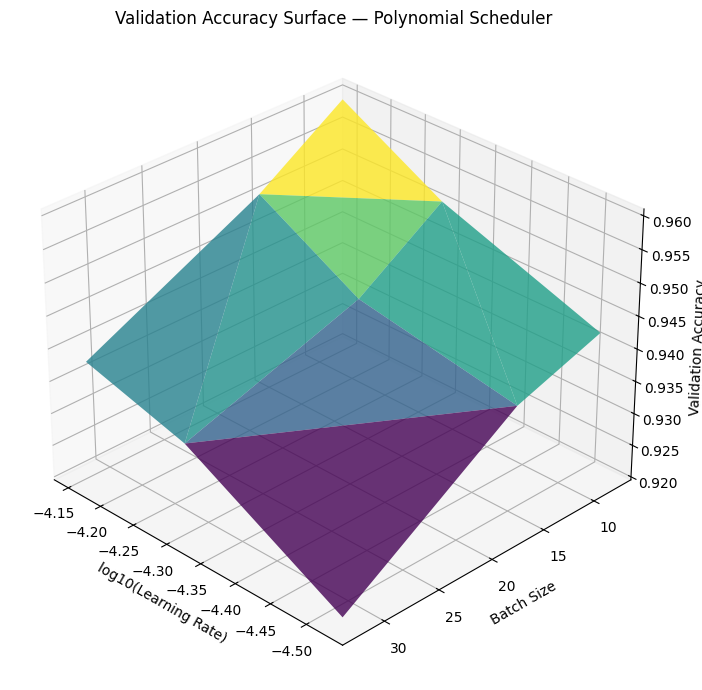

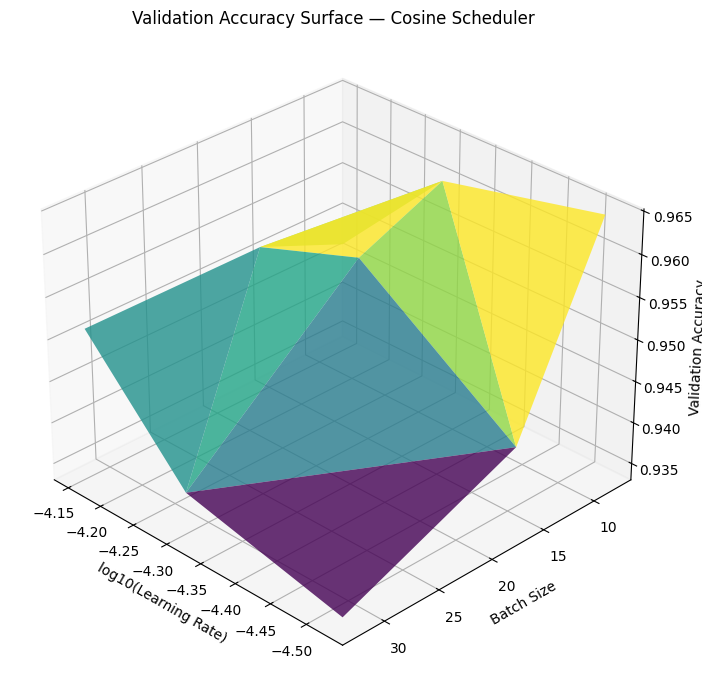

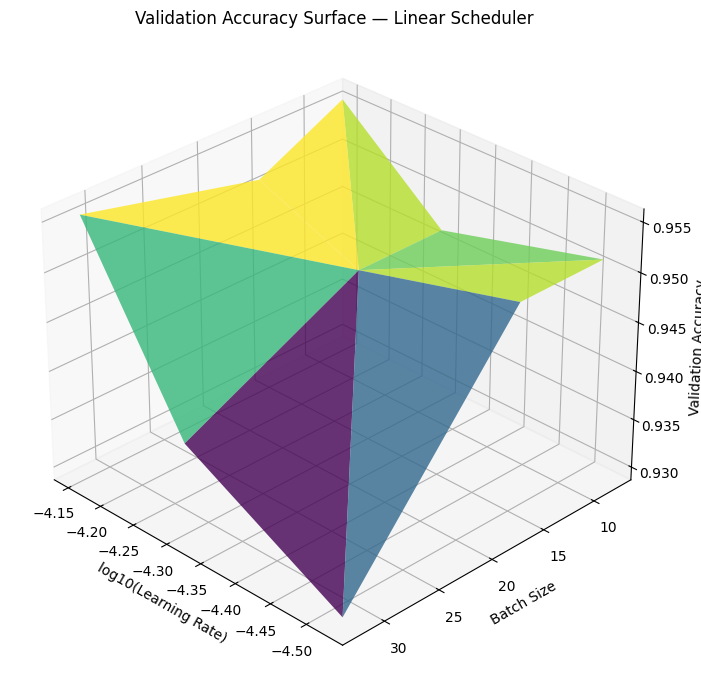

In [13]:
# 3D Surface Plots
for scheduler in schedulers:
    subset = results_df[results_df["scheduler"] == scheduler]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    xs = np.log10(subset["lr"])
    ys = subset["batch_size"]
    zs = subset["val_accuracy"]

    ax.plot_trisurf(xs, ys, zs, cmap=cm.viridis, edgecolor='none', alpha=0.8)
    ax.set_title(f"Validation Accuracy Surface — {scheduler.capitalize()} Scheduler")
    ax.set_xlabel("log10(Learning Rate)")
    ax.set_ylabel("Batch Size")
    ax.set_zlabel("Validation Accuracy")
    ax.view_init(elev=30, azim=135)
    plt.tight_layout()
    plt.show()

## Grid Search Analysis

### Optimal Configuration

The highest validation accuracy (0.9646) was achieved with:
- **Learning Rate:** `3e-5`  
- **Scheduler:** `cosine`  
- **Batch Size:** `8`  

This combination makes sense: smaller batches introduce regularization, and cosine decay allows the model to converge gradually—particularly important on small datasets.

### Learning Rate Observations

- `3e-5` and `5e-5` consistently outperformed `7e-5`.
- Higher learning rates like `7e-5` often led to faster convergence but poorer generalization, likely due to overshooting.
- Given our moderate dataset size and the stability demands of fine-tuning DistilBERT, smaller learning rates better preserved performance.

### Batch Size Trends

- Batch size `8` led across all schedulers.
- Smaller batches inject gradient noise, which can act as a form of implicit regularization.
- Batch size `32` consistently underperformed, likely due to overly smooth gradient updates and reduced generalization capacity.

### Scheduler Comparison

- Cosine decay was the most stable and yielded the highest peak accuracies.
- Polynomial decay came close and may benefit from early learning rate drops when paired with small batch sizes.
- Linear decay, while effective in general, was less well-suited to the short 2-epoch regime used in our grid search.

### Interplay Between Parameters

Performance was highest when using:
- Smaller batch sizes (8 or 16)
- Lower learning rates (3e-5 or 5e-5)
- Smooth schedulers (cosine or polynomial)

These components reinforce each other: small batches benefit from gradual learning rate decay, while lower learning rates reduce the risk of overfitting during fine-tuning.

### Results

- Batch size `8` is confirmed as best — all top results used it.
- Cosine scheduler dominated the top slot with the highest validation accuracy.
- Between `3e-5`, `5e-5`, and `7e-5`, the learning rate `3e-5` achieved the best accuracy with the lowest validation loss in this run, and it has been consistently strong across prior experiments.

**Final Optimal Parameters:**

`learning_rate = 3e-5`, `scheduler = cosine`, `batch_size = 8` 

## Optimizers

With the learning rate, batch size, and scheduler fixed at their optimal values (`3e-5`, `8`, and `cosine` respectively), the next focus is the choice of optimizer — a core component governing how model weights are updated during training.

Although Adam and AdamW are widely adopted for transformer fine-tuning, this experiment tests a broader set of optimizers to evaluate whether alternative strategies can yield performance improvements on this dataset.

### Tested Optimizers

- **Adam / AdamW:** Adaptive optimizers well-suited for sparse gradients; AdamW decouples weight decay from gradient updates, which can improve regularization.
- **RMSprop:** Designed to handle non-stationary objectives effectively — useful for sentence classification tasks with variability in input length and sentiment.
- **SGD:** A non-adaptive baseline, included to benchmark the benefits of adaptive learning strategies.
- **Nadam:** A variant of Adam that integrates Nesterov momentum, potentially enhancing convergence on smaller datasets.

All optimizers are paired with the same parameters as an ablation experiment. A consistent custom bin-weighted loss function is used across runs to ensure comparability.


In [15]:
# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Token length and binning
def compute_length_and_bin(example):
    length = len(tokenizer.tokenize(example["sentence"]))
    example["token_length"] = length
    return example

def assign_bin(example):
    length = example["token_length"]
    if length <= q1:
        example["bin_index"] = 0
    elif length <= q2:
        example["bin_index"] = 1
    else:
        example["bin_index"] = 2
    return example

# Apply length
dataset = dataset.map(compute_length_and_bin)
lengths = dataset["train"]["token_length"]
q1, q2 = np.percentile(lengths, [33, 66])
dataset = dataset.map(assign_bin)

# Tokenization
def tokenize_with_bin(example):
    tokens = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=256)
    tokens["label"] = example["label"]
    tokens["bin_index"] = example["bin_index"]
    return tokens

tokenized_datasets = dataset.map(tokenize_with_bin, batched=True)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)
static_train = train_val_split["train"]
static_val = val_test_split["train"]

# Compute dynamic weight matrix
bin_class_counts = defaultdict(Counter)
for row in static_train:
    bin_class_counts[row["bin_index"]][row["label"]] += 1

weight_matrix = np.zeros((3, 3))
for bin_id, class_counts in bin_class_counts.items():
    total = sum(class_counts.values())
    for cls, count in class_counts.items():
        weight_matrix[bin_id][cls] = total / (len(class_counts) * count)
weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

# TF dataset loader
def to_tf_dataset(split, shuffle=False, batch_size=8):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=None
    )

tf_train = to_tf_dataset(static_train, shuffle=True, batch_size=8)
tf_val = to_tf_dataset(static_val, shuffle=False, batch_size=8)

# Training step calculation
steps_per_epoch = len(tf_train)
total_steps = steps_per_epoch * 2
warmup_steps = int(0.1 * total_steps)

# Custom wrapper (same as before)
class CustomDistilBERT(tf.keras.Model):
    def __init__(self, base_model, weight_tensor):
        super().__init__()
        self.model = base_model
        self.weight_tensor = weight_tensor

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

    def train_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True).logits
            weights = tf.gather_nd(
                self.weight_tensor,
                tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
            )
            loss = self.loss_fn(y_true, logits)
            weighted_loss = tf.reduce_mean(loss * weights)
        grads = tape.gradient(weighted_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def test_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        logits = self.model(x, training=False).logits
        weights = tf.gather_nd(
            self.weight_tensor,
            tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
        )
        loss = self.loss_fn(y_true, logits)
        weighted_loss = tf.reduce_mean(loss * weights)
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def call(self, inputs):
        inputs = inputs.copy()
        inputs.pop("bin_index", None)
        return self.model(inputs)

# Optimizers to test (use cosine scheduler)
optimizer_names = ["Adam", "AdamW", "RMSprop", "SGD", "Nadam"]
results = []

def build_optimizer(name):
    base = getattr(tf.keras.optimizers, name)
    return base(learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=3e-5,
        decay_steps=total_steps,
        alpha=0.0  # final LR as a fraction of initial
    ))

# Run optimizer experiments
for opt_name in optimizer_names:
    print(f"\nTraining with optimizer: {opt_name}")

    base_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
    base_model.trainable = True
    model = CustomDistilBERT(base_model, weight_tensor)
    optimizer = build_optimizer(opt_name)

    model.compile(
        optimizer=optimizer,
    )

    history = model.fit(
        tf_train,
        validation_data=tf_val,
        epochs=2,
        verbose=0
    )

    final_val_acc = history.history["val_accuracy"][-1]
    final_val_loss = history.history["val_loss"][-1]

    results.append({
        "optimizer": opt_name,
        "val_accuracy": final_val_acc,
        "val_loss": final_val_loss
    })

    print(f"→ Val Accuracy: {final_val_acc:.4f}, Val Loss: {final_val_loss:.4f}")

# Show results
results_df = pd.DataFrame(results).sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)
display(results_df)



Training with optimizer: Adam


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.0263

Training with optimizer: AdamW


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.0302

Training with optimizer: RMSprop


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9558, Val Loss: 0.0283

Training with optimizer: SGD


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.6106, Val Loss: 1.4403

Training with optimizer: Nadam


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9513, Val Loss: 0.0318


,optimizer,val_accuracy,val_loss
0,RMSprop,0.955752,0.028267
1,Nadam,0.951327,0.031802
2,AdamW,0.946903,0.030155
3,Adam,0.942478,0.026328
4,SGD,0.610619,1.440260


### Results

- **RMSprop** achieved the highest validation accuracy (`0.9558`) and the lowest validation loss (`0.0283`), indicating both accurate and confident predictions.
- **Nadam** and **AdamW** followed closely but trailed slightly in both metrics.
- **Adam** underperformed relative to its adaptive counterparts in this configuration.
- **SGD** showed significantly lower accuracy and high loss, confirming that adaptive optimizers are better suited for this task.

**Conclusion:** RMSprop is selected as the final optimizer due to its superior performance, stability under bin-weighted loss, and ability to generalize effectively in short-epoch fine-tuning scenarios.


## Dropout Layer

The next step is to test whether adding dropout layers improves performance.  

Dropout layers serve as a form of regularization — intuitively, this is like randomly "turning off" some neurons during training to prevent overfitting.

We retain the previously established optimal parameters:
- **Learning Rate:** `3e-5`
- **Batch Size:** `8`
- **Scheduler:** `cosine`
- **Optimizer:** `RMSprop`

We test the following dropout rates:
`[0.0, 0.1, 0.2, 0.3, 0.4]`

These values were chosen to span a representative range:
- **0.0:** No dropout — serves as a control to assess the necessity of regularization.
- **0.1–0.2:** Common values in transformer fine-tuning, particularly for moderately sized datasets.
- **0.3–0.4:** Higher regularization — included to examine whether stronger dropout improves robustness or leads to underfitting.


In [18]:
def build_and_train_with_dropout(dropout_rate, weight_tensor, tf_train, tf_val, steps_per_epoch):
    total_steps = steps_per_epoch * 3
    base_model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=3
    )
    base_model.config.dropout = dropout_rate
    base_model.config.attention_dropout = dropout_rate
    base_model.trainable = True

    model = CustomDistilBERT(base_model, weight_tensor)

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=3e-5,
        decay_steps=total_steps,
        alpha=0.0
    )
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
    )

    history = model.fit(
        tf_train,
        validation_data=tf_val,
        epochs=3,
        verbose=0
    )

    return {
        "dropout": dropout_rate,
        "val_accuracy": history.history["val_accuracy"][-1],
        "val_loss": history.history["val_loss"][-1]
    }


In [19]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4]
steps_per_epoch = len(tf_train)

dropout_results = [
    build_and_train_with_dropout(rate, weight_tensor, tf_train, tf_val, steps_per_epoch)
    for rate in dropout_rates
]

dropout_df = pd.DataFrame(dropout_results).sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)
display(dropout_df)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

,dropout,val_accuracy,val_loss
0,0.4,0.960177,0.009256
1,0.3,0.951327,0.009724
2,0.0,0.946903,0.010639
3,0.2,0.946903,0.009491
4,0.1,0.946903,0.010525


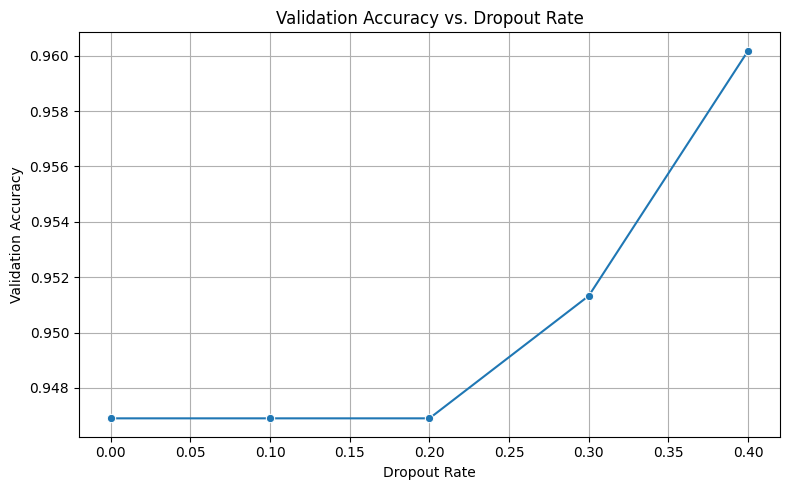

In [20]:
# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=dropout_df.sort_values(by="dropout"), x="dropout", y="val_accuracy", marker="o")
plt.title("Validation Accuracy vs. Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

### Results

The best performance was achieved at a dropout rate of **0.4**, with a validation accuracy of **0.9602** and the lowest validation loss (**0.0093**) across all tested configurations. This suggests that stronger regularization was beneficial in this setup, likely due to the small dataset.

Interestingly, all lower dropout rates (including 0.0) resulted in the same accuracy of **0.9469**, but with slightly higher loss values — indicating less confident predictions. 

A dropout rate of **0.3** also performed well, ranking second in both accuracy and loss, reinforcing the conclusion that moderate to high dropout improves generalization in this case.

**Conclusion:** A dropout rate of `0.4` is selected going forward, offering the best trade-off between accuracy and confidence.

# Are We Overfitting?

With most hyperparameters now tuned and regularization techniques applied, it is important to assess whether the model is overfitting to the training data.

Overfitting occurs when the model performs well on the training set but fails to generalize to unseen data — typically revealed by a significant gap between training and validation metrics.

In this section, training and validation loss/accuracy will be tracked across epochs using the best-performing configuration so far:

- **Learning Rate:** `3e-5`
- **Batch Size:** `8`
- **Scheduler:** `cosine`
- **Optimizer:** `RMSprop`
- **Dropout:** `0.4`

The goal is to visualize training dynamics and determine whether additional regularization or early stopping may be necessary.

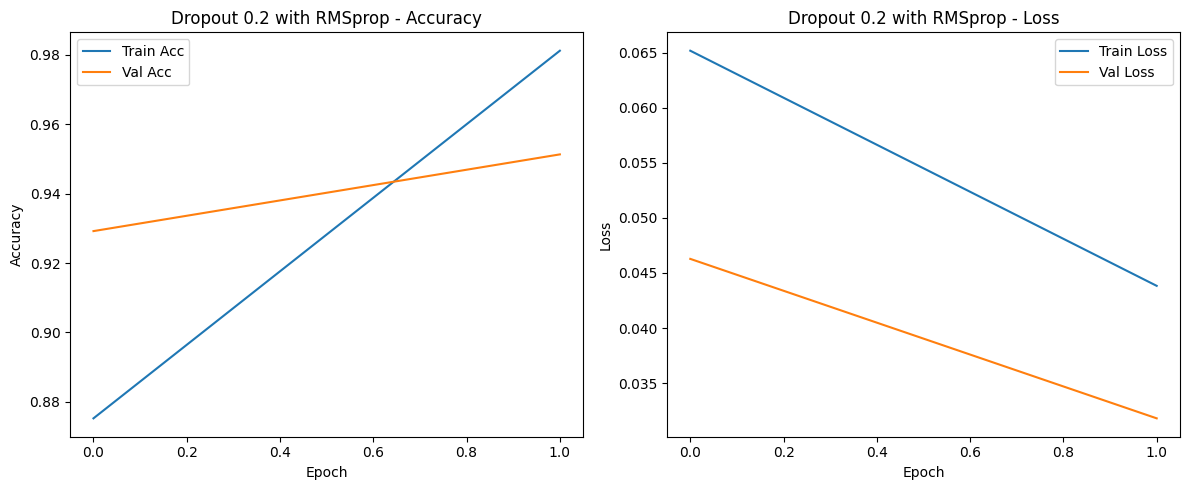

15/15 [==============================] - 2s 45ms/step
Test Accuracy: 0.9559


In [21]:
def plot_training_curves(history, title="Training vs Validation"):

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history, title="Dropout 0.4 with RMSprop")

# Evaluate on holdout test set
X_test = tf_test.map(lambda x, y: {
    "input_ids": x["input_ids"],
    "attention_mask": x["attention_mask"],
    "bin_index": x["bin_index"]
})
y_test = np.concatenate([y.numpy() for _, y in tf_test], axis=0)

logits = model.predict(X_test).logits
y_pred = np.argmax(logits, axis=1)

test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")


### Overfitting Check

The training and validation curves show no immediate signs of overfitting:

- **Accuracy:** Both training and validation accuracy improve steadily over the 2 epochs, with no significant gap forming. The training curve is steeper, as expected, but the validation curve tracks closely behind.
- **Loss:** Both training and validation loss decrease in parallel, with the validation loss consistently lower than the training loss — a sign that the model is not simply memorizing the training data.

The absence of divergence between training and validation metrics suggests the model is generalizing well under the current setup. Dropout at `0.2` appears to provide a healthy level of regularization, although previous results showed stronger performance at `0.4`, which may further suppress overfitting.

**Conclusion:** There is no clear evidence of overfitting. The training is stable, and regularization appears effective at this stage.


# Final Parameters:

- **Learning Rate:** `3e-5`
- **Batch Size:** `8`
- **Scheduler:** `cosine`
- **Optimizer:** `RMSprop`
- **Dropout:** `0.4`

Continuation back in [Main Notebook](../part1_finetuning_Distilbert.ipynb)